# Part A: Analysing Text Data

### Importing required libraries for all the PART A tasks

In [1]:
import re
import nltk
from nltk.corpus import stopwords
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#### Step 01: Import ​ pyspark ​ and initialize Spark

In [4]:
# create entry points to spark
from pyspark import SparkContext, SparkConf # Spark
from pyspark.sql import SparkSession # Spark SQL

# We add this line to avoid an error : "Cannot run multiple SparkContexts at once". 
# If there is an existing spark context, we will reuse it instead of creating a new context.
sc = SparkContext.getOrCreate()

conf = SparkConf()
conf.set('spark.app.name','Analysing TEXT data')
conf.set('spark.master','local[*]')  # Use all cores in the machine
conf.set('spark.ui.port','4040') # set default port 4040

# local[*]: run Spark locally with as many working processors as logical cores on your machine.
# In the field of `master`, we use a local server with as many working processors (or threads) as possible (i.e. `local[*]`).  
# If there is no existing spark context, we now create a new context
if (sc is None):
    sc = SparkContext(conf=conf)
    
spark = SparkSession(sparkContext=sc)

#### Step 02: Create Resilient Distributed Datasets (RDDs)

In [5]:
rdd_scrum = sc.textFile('Scrum Handbook.txt')
rdd_agile = sc.textFile('Agile Processes  in Software Engineering  and Extreme Programming.txt')

In [12]:
print('Total number of lines in scrum dataset = {}'.format(rdd_scrum.count()))

Total number of lines in scrum dataset = 4617


In [13]:
print('Total number of lines in agile dataset = {}'.format(rdd_agile.count()))

Total number of lines in agile dataset = 21569


#### Step 03: ​ Cleaning/Manipulating text.

Write a function that performs the following tasks on the RDDs:
1. Removes all characters which are not alphabets except space(s).
2. Changes all upper case letters to lowercase..
3. Removes all leading or trailing spaces.

In [15]:
def clean_text(input_rdd):
    pattern = re.compile('[^A-Za-z ]')
    no_empty_lines_rdd = input_rdd.filter(lambda x : x !='').filter(lambda x:x!=' ')
    clean_rdd = no_empty_lines_rdd.map(lambda x: re.sub(pattern,'',x)).map(lambda x:x.strip().lower())
    return clean_rdd

Function clean_text takes the raw rdd as input
* '[^A-Za-z ]' - pattern to match non alphabet and not space character
* **filter()** - filter blank lines or lines with just a space
* mapped each line of the rdd with the **lambda** function to substitute any non aplha and not space characters with nothing.
* **.strip()** - is used to remove any trailing spaces
* **.lower()** - converts the text to lower case

In [16]:
scrum_clean_text_rdd = clean_text(rdd_scrum)
agile_clean_text_rdd = clean_text(rdd_agile)

In [20]:
agile_clean_text_rdd.take(10)

['lnbip',
 'i helen sharp',
 'tracy hall eds',
 'agile processes',
 'in software engineering',
 'and extreme programming',
 'th international conference xp',
 'edinburgh uk may',
 'proceedings',
 'springer open']

In [21]:
scrum_clean_text_rdd.take(10)

['jeff sutherlands',
 'scrum handbook',
 'everything',
 'you need',
 'to know',
 'to start',
 'a scrum project',
 'in your',
 'organization',
 'scrum']

#### Step 04: Transforming the Data/Counting the words

In [31]:
# function to count frequency of each unique word in the dataset
def word_counts(clean_text):
    word_count_rdd = clean_text.flatMap(lambda x:x.split(' ')).map(lambda x:(x,1)).reduceByKey(lambda x,y:x+y)
    word_count_sorted = word_count_rdd.map(lambda x:(x[1],x[0])).sortByKey(ascending = False).map(lambda x:(x[1],x[0]))
    return word_count_sorted

The function "word_counts" takes the cleaned text rdd as input<br>
* **.split(" ")** by spaces reduces the text to tokens
* lambda function is used with map to assign each word a value 1 in a key,value pair.
* **reduceByKey()** function is used to take summation of values corresponding to a single key value
* Finally the word count rdd is sorted by interchanging the key,value

In [23]:
scrum_word_count_rdd = word_counts(scrum_clean_text_rdd)
agile_word_count_rdd = word_counts(agile_clean_text_rdd)

In [28]:
scrum_word_count_rdd.take(20)

[('the', 1238),
 ('of', 537),
 ('and', 534),
 ('to', 477),
 ('a', 451),
 ('', 445),
 ('scrum', 395),
 ('in', 360),
 ('is', 348),
 ('team', 260),
 ('product', 232),
 ('for', 195),
 ('that', 181),
 ('it', 165),
 ('on', 149),
 ('sprint', 146),
 ('this', 142),
 ('with', 132),
 ('as', 124),
 ('are', 119)]

In [29]:
agile_word_count_rdd.take(20)

[('the', 8145),
 ('and', 3965),
 ('of', 3944),
 ('to', 3714),
 ('', 3244),
 ('in', 3076),
 ('a', 2701),
 ('is', 1539),
 ('that', 1355),
 ('for', 1194),
 ('as', 1028),
 ('on', 1015),
 ('we', 975),
 ('with', 969),
 ('software', 922),
 ('this', 915),
 ('are', 784),
 ('agile', 748),
 ('it', 741),
 ('development', 737)]

#### Step 05: Removing Stop Words

In [36]:
stop_words = set(stopwords.words('english')) # list of english stop words
def remove_stop_words(clean_text):
    text_to_words = word_counts(clean_text)
    no_stop_words_text = text_to_words.filter(lambda x : x[0] not in stop_words and x[0]!='')
    return no_stop_words_text

The function "remove_stop_words" takes cleaned text rdd as input
* **word_counts()** function is used to convert cleaned text into word tokens with frequecy as values, in key,value pairs
* words are filtered using **.filter()**. Only keys that are not present in stopwords list are taken
* Keys that were empty (' ') have aslo been removed

In [40]:
scrum_no_stop_words_rdd = remove_stop_words(scrum_clean_text_rdd)
agile_no_stop_words_rdd = remove_stop_words(agile_clean_text_rdd)

In [45]:
scrum_no_stop_words_rdd.distinct().count()

2936

In [46]:
agile_no_stop_words_rdd.distinct().count()

9611

#### Step 06: Find the average occurrence of a word

In [47]:
def average_occurrence(no_stop_words_rdd):
    total_words = no_stop_words_rdd.map(lambda x:(x[1])).sum()
    unique_words_count = no_stop_words_rdd.flatMap(set).distinct().count()
#     number_of_words = no_stop_words_rdd.countDistinctByKey()
    average_word_occurrence =  round(total_words/unique_words_count,3)
    return 'Total Words =' + str(total_words)+'   ' + 'Total Unique Words='+str(unique_words_count) \
            +'   '+ 'Average word count=' +str(round(average_word_occurrence,3))

Function **average_occurrence()** takes the rdd with no stop words as input
* The frequencies of each word are aggregated using **map()** with **sum()** function
* Unique number of words in the input rdd is calculated 
* Finally the average is calculated by dividing total_words by unique_words_count
* **round()** is used to roundoff the decimal value, in our case to 3 decimal points

In [48]:
average_occurrence(scrum_no_stop_words_rdd)

'Total Words =10810   Total Unique Words=2988   Average word count=3.618'

In [49]:
average_occurrence(agile_no_stop_words_rdd)

'Total Words =79056   Total Unique Words=9779   Average word count=8.084'

#### Step 7: Exploratory data analysis

**Compare the distribution of words in Book1 and Book2. The data spans many orders
of magnitude and the features of the distribution not quite evident in the linear space.
Therefore, use log scale (base 10) to plot the graph. Explain your understanding
based on the graphs?**

Saving the frequencies of the words from each data rdd for plotting

In [70]:
scrum_plot = scrum_no_stop_words_rdd.map(lambda x:x[1]).collect()

In [71]:
agile_plot = agile_no_stop_words_rdd.map(lambda x:x[1]).collect()

(array([1.26557767e-02, 2.16116405e-05, 4.32232811e-06, 4.32232811e-06,
        4.32232811e-06]),
 array([  1. ,  79.8, 158.6, 237.4, 316.2, 395. ]),
 <a list of 5 Patch objects>)

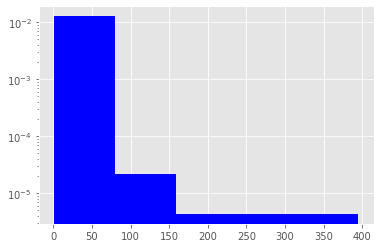

In [110]:
plt.hist(scrum_plot,log=True,label='Scrum handbook word count',color='b',density=True,bins=5)

* Right skewed data
* Maximum number of words are in frequency range 0-75
* Least number of words fall under 150-400 frequecy bins

(array([6.48686681e-03, 1.96571721e-05, 5.42266818e-06, 6.77833522e-07,
        1.35566704e-06, 6.77833522e-07]),
 array([  1. , 154.5, 308. , 461.5, 615. , 768.5, 922. ]),
 <a list of 6 Patch objects>)

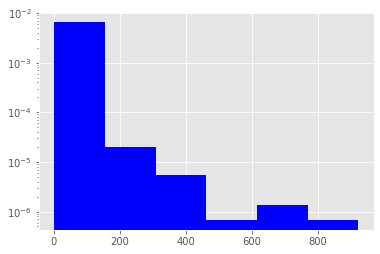

In [106]:
plt.hist(agile_plot,log=True,label='Agile processes word count',color='b',bins=6,density=True)

* Right skewed data
* Maximum number of words are in frequency range 0-175
* Least number of words fall under 430-620 and 760-950 frequecy bins

#### Compare the top 15 most common words in Book1 and Book2. Plot the graphs and explain your understanding of the graph?

I have extracted the words and their frequecies as x and y values for plotting. 
* **x_val_file** contains words in that file
* **y_val_file** contains frequecies corresponding to each word

In [51]:
x_val_scum = [x[0] for x in scrum_no_stop_words_rdd.collect()]
y_val_scrum = [y[1] for y in scrum_no_stop_words_rdd.collect()]
x_val_agile = [x[0] for x in agile_no_stop_words_rdd.collect()]
y_val_agile = [y[1] for y in agile_no_stop_words_rdd.collect()]

#### Scrum "Top 15 most common words"

Total words are 2936
Max frequency of a word is 395
Min frequency of a word is 1


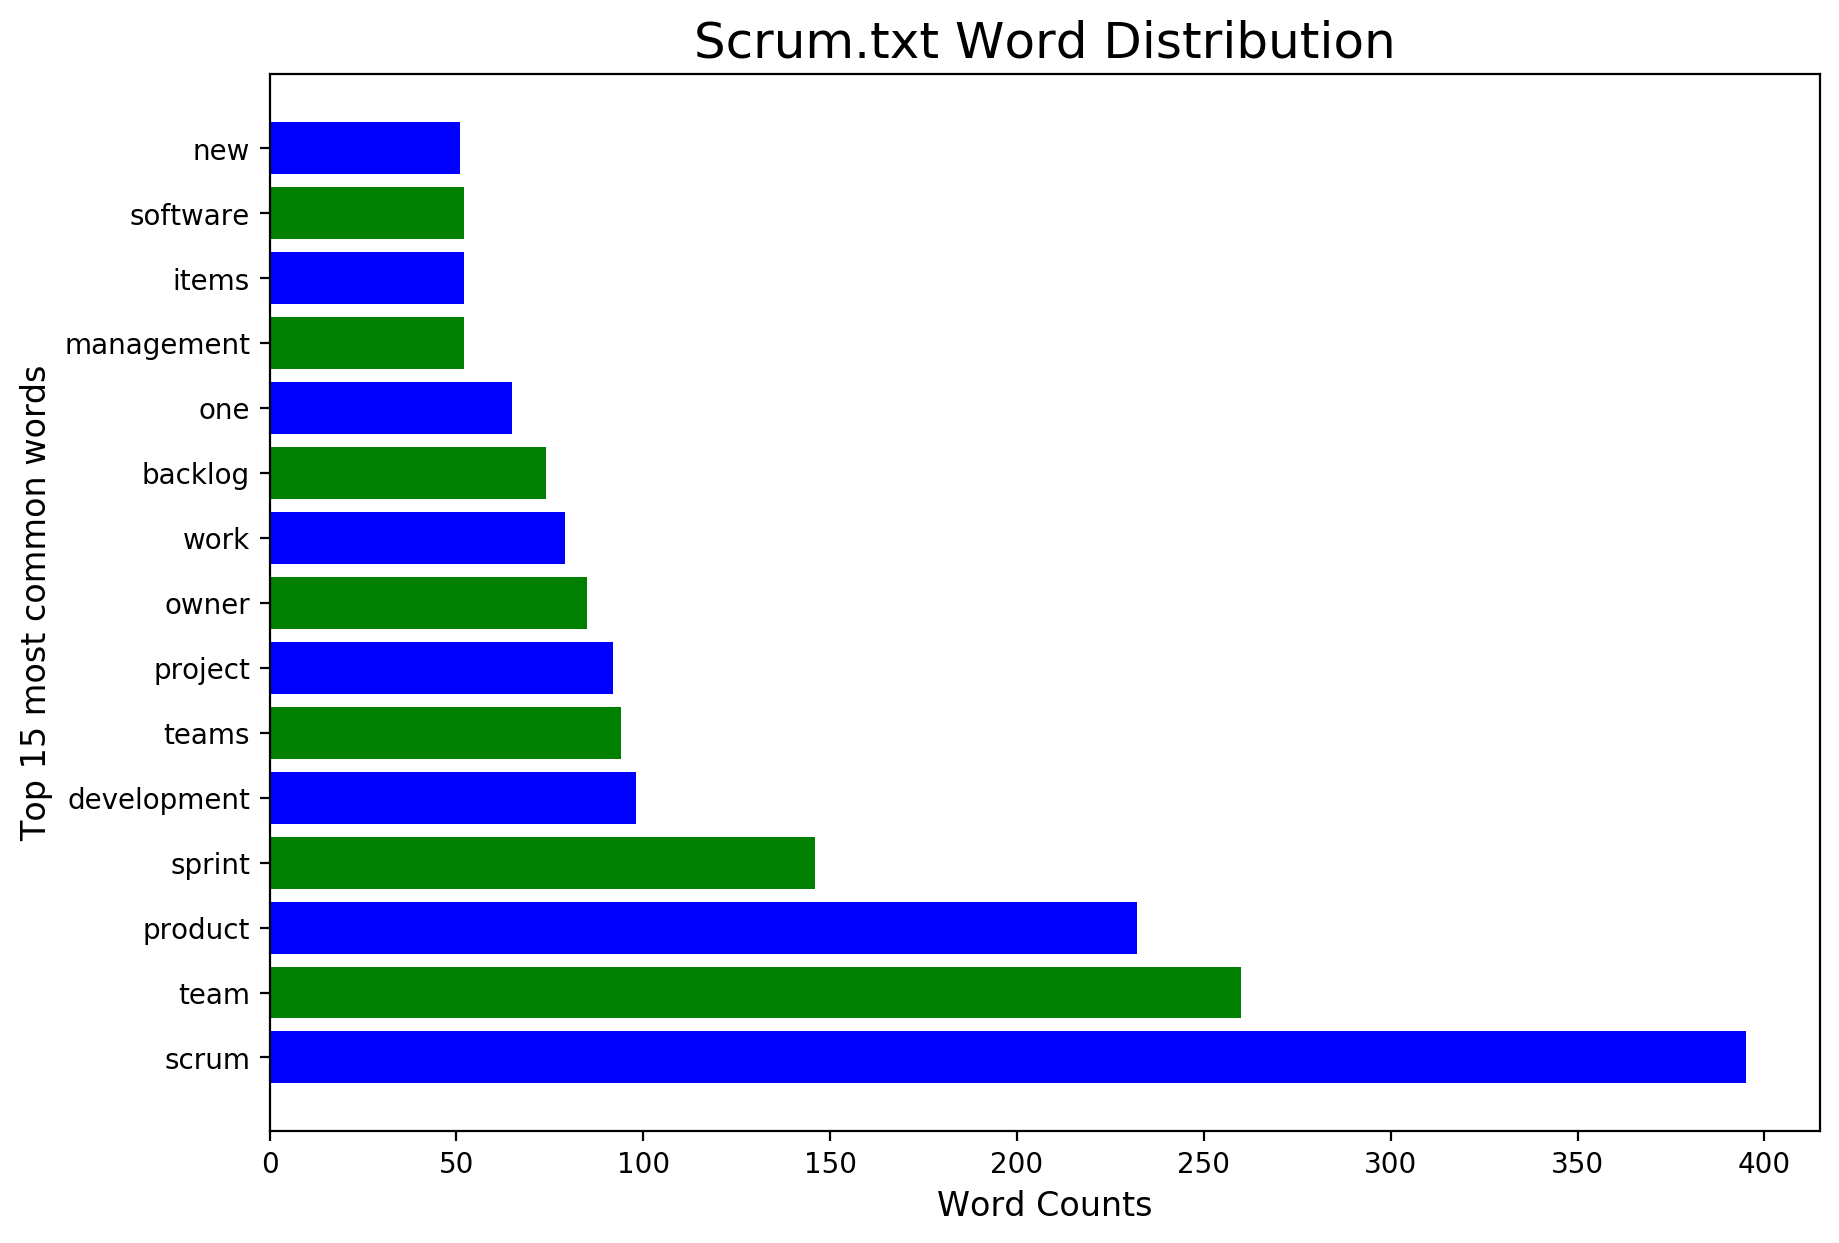

In [61]:
print("Total words are {}".format(len(y_val_scrum)))
print("Max frequency of a word is {}".format(max(y_val_scrum)))
print("Min frequency of a word is {}".format(min(y_val_scrum)))
plt.figure(figsize=(10,7),dpi=200)
plt.barh(x_val_scum[0:15],y_val_scrum[0:15],color='bg')
plt.xlabel("Word Counts",fontsize=12)
plt.ylabel("Top 15 most common words",fontsize=12)
plt.title("Scrum.txt Word Distribution",fontsize=18)
plt.show()

* Maximum frequent word in the scrum dataset is "SCRUM" which is 395
* The top three frequent words are responsible for nearly 30% of the total word count

#### Agile "Top 15 most common words"

Total words are 9611
Max frequency of a word is 922
Min frequency of a word is 1


Text(0.5, 1.0, 'Agile.txt Word Distribution')

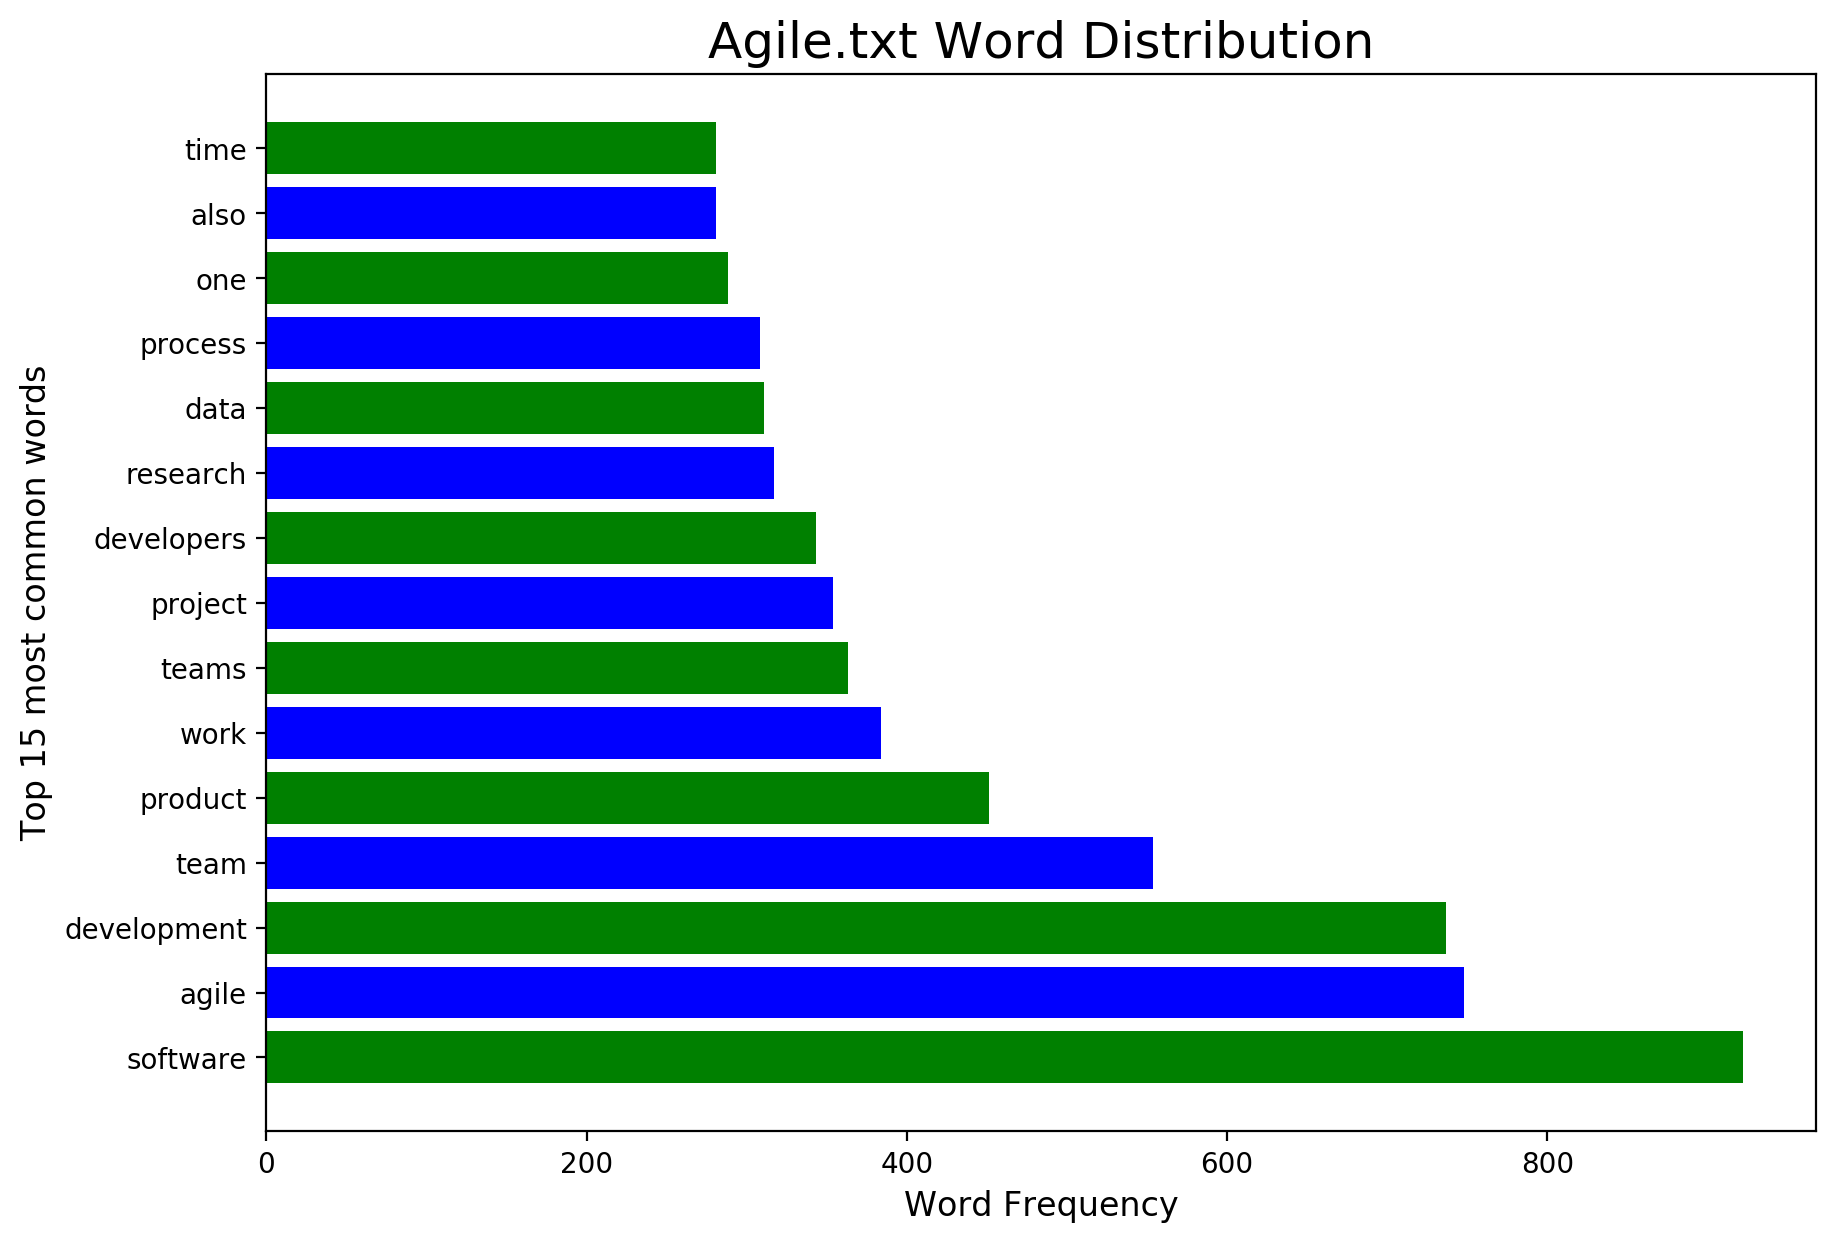

In [60]:
print("Total words are {}".format(len(y_val_agile)))
print("Max frequency of a word is {}".format(max(y_val_agile)))
print("Min frequency of a word is {}".format(min(y_val_agile)))
plt.figure(figsize=(10,7),dpi=200)
plt.barh(x_val_agile[0:15],y_val_agile[0:15],color='gb')
plt.xlabel("Word Frequency",fontsize=12)
plt.ylabel("Top 15 most common words",fontsize=12)
plt.title("Agile.txt Word Distribution",fontsize=18)

* Maximum frequent word in the agile dataset is "SOFTWARE" which is 922. It is responsible for almost 10% of the total word count
* The top three frequent words are responsible for nearly 26% of the total word count